# QuickStart

## Working with data
- ```torch.utils.data.DataSet``` stores the samples and their corresponding labels
- ```torch.utils.data.DataLoader``` wraps an iterable around the ```Dataset```
- ```torchvision.datasets``` module contains ```Dataset``` objects and includes tow arguments: ```transform``` and ```target_transform``` to modify the samples and labels respectively

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12310274.20it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210564.88it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3895218.54it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13102109.83it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the ```Dataset``` as an argument to ```DataLoader```. This wraps an iterable over our datasets, and support automatic batching, sampling, shuffling, and multiprocess data loading.

In [4]:
batch_size = 64 # each element in the dataloader iterable will return a batch of 64 features and labels

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
  print(f"Shape of ≈ X [N, C, H, W]: {X.shape}")
  print(f"Shape of ≈ y: {y.shape} {y.dtype}")
  break

Shape of ≈ X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of ≈ y: torch.Size([64]) torch.int64


## Creating Models
To define a nn in PyTorch, we create a class that inherits from ```nn.Module```.  
- ```___init___()``` : define the layers of the nn 
- ```forward()``` : specify how data will pass through the network

In [5]:
# Get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits


model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

- train 
  - makes predictions on the training dataset
  - backpropagates the prediction error to adjust the model's parameters

In [8]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss : {loss:>7f} [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loos_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0 
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n")

In [10]:
epochs = 5

for t in range(epochs):
  print(f"Epoch {t +1}\n----------------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
  
print("Done")

Epoch 1
----------------------------------------
loss : 2.316387 [   64/60000]
loss : 2.300258 [ 6464/60000]
loss : 2.278380 [12864/60000]
loss : 2.272400 [19264/60000]
loss : 2.240164 [25664/60000]
loss : 2.220697 [32064/60000]
loss : 2.231028 [38464/60000]
loss : 2.193226 [44864/60000]
loss : 2.198538 [51264/60000]
loss : 2.155947 [57664/60000]
Test Error: 
 Accuracy: 43.3%, avg loss: 2.154220

Epoch 2
----------------------------------------
loss : 2.169596 [   64/60000]
loss : 2.161458 [ 6464/60000]
loss : 2.097149 [12864/60000]
loss : 2.117272 [19264/60000]
loss : 2.056101 [25664/60000]
loss : 2.000705 [32064/60000]
loss : 2.034314 [38464/60000]
loss : 1.948967 [44864/60000]
loss : 1.959059 [51264/60000]
loss : 1.881269 [57664/60000]
Test Error: 
 Accuracy: 57.3%, avg loss: 1.886926

Epoch 3
----------------------------------------
loss : 1.920177 [   64/60000]
loss : 1.900504 [ 6464/60000]
loss : 1.774097 [12864/60000]
loss : 1.818250 [19264/60000]
loss : 1.698489 [25664/60000]
l

## Saving Models
- serialize the internal state dictionary(containing the model parameter) : a common way to save a model

In [11]:
torch.save(model.state_dict(), "model.pth")
print('Saved PyTorch Model State to model.pth')

Saved PyTorch Model State to model.pth


## Loading Model
The process for loading a model includes re-creating the model structure and loading the state dictionary into it

In [12]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [13]:
# used to make prediction
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f"Predicted: '{predicted}', Actual: '{actual}'")

Predicted: 'Ankle boot', Actual: 'Ankle boot'


# Tensors

## Initializing a Tensor

In [14]:
import torch
import numpy as np

In [15]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

In [16]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [17]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype = torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.7121, 0.3797],
        [0.7286, 0.6256]]) 



In [18]:
shape = (2, 3, )
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor} \n")

Random Tensor: 
 tensor([[0.3274, 0.7052, 0.3046],
        [0.9286, 0.8899, 0.7434]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]]) 



## Attributes of a Tensor

In [20]:
tensor = torch.rand(3, 4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


## Operations on Tensors

In [21]:
# We move our tensor to the GPU uf available
if torch.cuda.is_available():
  tensor = tensor.to("cuda")

- standard numpy-like indexing and slicing

In [22]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:, 1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


- joining tensors

In [23]:
t1 = torch.cat([tensor, tensor, tensor], dim = 1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


- Arithmatic operations

In [25]:
# matrix multiplication
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out = y3)


# element-wise product
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out = z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

- single-element tensors

```
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
```

In [26]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


- in-place operations

In [29]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


## Bridge with Numpy

- Tensor to Numpy array

In [30]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [31]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


- Numpy array to tensor

In [32]:
n = np.ones(5)
t = torch.from_numpy(n)

In [33]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


# DataSets & DataLoaders

## Loading a Dataset
- ```root``` : path where the train/test data is stored
- ```train``` : specifies training or test dataset
- ```download=True``` : downloads the data from the internet if it's not available at ```root```
- ```transform``` and ```target_transform``` : specifiy the feature and label transformations

In [34]:
import torch 
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

## Iterating and Visualizing the Dataset

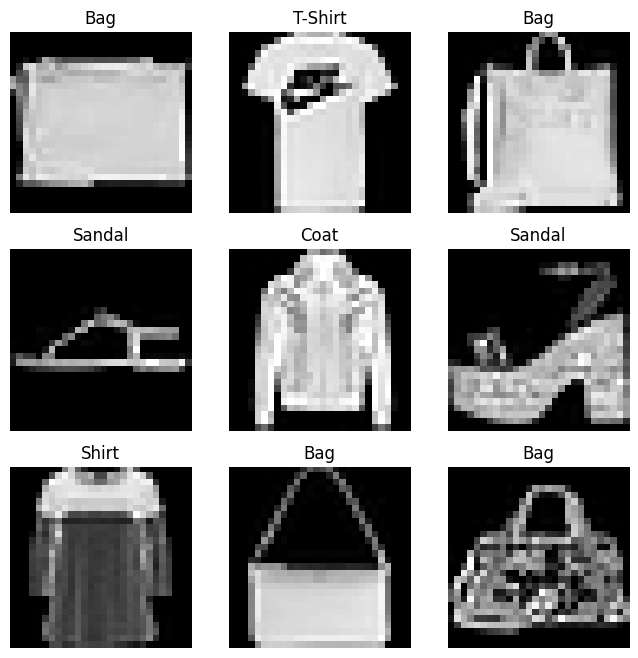

In [35]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size = (1, )).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap = "gray")

plt.show()

## Creating a Custom Dataset for your files
A custom Dataset class must implement ```__init__, __len__```, and ```__getitem__```


In [36]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.ilod[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

- ```init``` : run once when instantiating the Dataset object
- ```len``` : returns the number of samples in our dataset
- ```getitem``` : loads and returns a sample from the dataset at the given index 'idx'. Based on the index, it identifies image's location on disk, converts that to a tensor using ```read_image```, retrives the corresponding label from the csv data in ```self.img_labels```, calls the transform functions on them, and returns the tensor image and corresponding label in a tuple.

## Preparing your data for training with DataLoaders

In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

## Iterate through the DataLoader

Feature batch shapeL torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


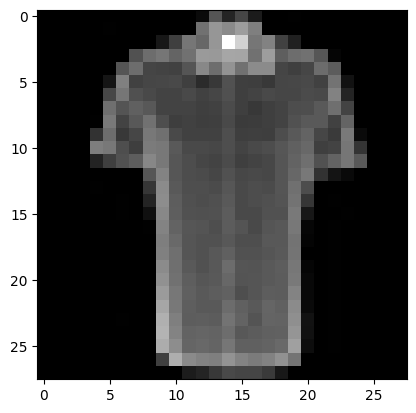

Label: 6


In [38]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shapeL {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = "gray")
plt.show()
print(f"Label: {label}")

# Transforms

All TorchVision datasets have two parameters 
- ```transform``` to modify the features
- ```target_transform``` to modify the labels

In [40]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform= Lambda(
        lambda y: torch.zeros(
            10, dtype = torch.float).scatter_(0, torch.tensor(y), value = 1)
    )
)

- ```ToTensor()``` : converts a PIL image or NumPy ```ndarray``` into a ```FloatTensor```. and scales the image's pixel intensity values in the range [0., 1.]

# Build the Neural Network

The ```torch.nn``` namespace provides all the building blocks you need to build your own nn.   
Every module in PyTorch subclasses the ```nn.Module```

In [41]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Get device for Training

In [42]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Define the Class
- define our nn by subclassing ```nn.Module```
- initialize the nn layers in ```__init__```


In [50]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [52]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [53]:
X = torch.rand(1, 28, 28, device = device)
logits = model(X)
pred_prob = nn.Softmax(dim = 1)(logits)
y_pred = pred_prob.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4])


## Model Layers
- sample minibatch : 3 images of size 28*28

In [54]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


```nn.Flatten``` layer : to convert each 2D 28*28 images into a contiguous array of 784 pixel values

In [55]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


```nn.Linear``` : a module that applies a linear transformation on the input using its stored weights and bias

In [57]:
layer1 = nn.Linear(in_features = 28*28, out_features = 20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


```nn.ReLU``` : non linear activations are what create the complex mappings between the model's inputs and outputs

In [58]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}\n\n")

Before ReLU: tensor([[-1.1101e-01,  3.6770e-01,  3.5414e-01, -3.1011e-01,  1.6600e-01,
         -2.0383e-01, -3.1476e-01,  1.9688e-01, -4.2367e-02, -8.0910e-02,
          9.1332e-02, -3.4437e-01,  2.9712e-01, -1.3748e-02,  2.2593e-01,
          3.4521e-01,  4.7541e-01,  5.8157e-01,  8.1083e-02,  2.7341e-01],
        [-2.4284e-01,  4.7201e-01,  5.3104e-01, -3.3553e-01,  6.8613e-02,
         -2.3469e-01,  1.5987e-01,  9.2000e-02, -9.4544e-02,  1.2607e-01,
         -2.0336e-01, -5.6899e-01, -8.2157e-02, -6.0379e-02,  6.6246e-02,
          1.7964e-01,  3.4409e-01,  2.6479e-01,  1.7856e-01,  3.9403e-01],
        [-3.7851e-01,  4.7272e-01,  6.2125e-01, -3.7991e-01, -1.0644e-01,
         -6.4350e-02, -1.7578e-01,  3.1275e-01, -8.2824e-02, -1.3948e-01,
         -9.2234e-03, -3.3431e-01,  6.4032e-01,  1.9905e-01,  1.6174e-01,
         -6.9857e-05,  3.2399e-01,  7.3774e-01,  1.4933e-01,  9.2322e-02]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.3677, 0.3541, 0.0000, 0.1660,

```nn.Sequential``` : an ordered container of modules

In [59]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

```nn.softmax``` : scaled to values [0, 1] representing the model’s predicted probabilities for each class  

```dim``` parameter indicates the dimension along which the values must sum to 1.

In [60]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

## Model Parameters
Subclassing ```nn.Module``` automatically tracks all fields defined inside your model object, and makes all parameters accessible using your model’s ```parameters()``` or ```named_parameters()``` methods.

In [61]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0285, -0.0252, -0.0192,  ...,  0.0310, -0.0017,  0.0044],
        [-0.0222,  0.0002, -0.0291,  ...,  0.0041,  0.0011,  0.0105]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0348,  0.0225], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0141, -0.0279,  0.0263,  ...,  0.0162,  0.0358, -0.0293],
        [ 0.0411, -0.0014,  0.0123,  ..., -0.0078, -0.0322,  0.0031]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# Automatic differentiation with ```torch.autograd```

In [62]:
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad = True)
b = torch.randn(3, requires_grad = True)

z = torch.matmul(x, w) + b

loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [63]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7ff86d2d83d0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7ff86d2d8cd0>


## Computing gradients

In [64]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2780, 0.2659, 0.2133],
        [0.2780, 0.2659, 0.2133],
        [0.2780, 0.2659, 0.2133],
        [0.2780, 0.2659, 0.2133],
        [0.2780, 0.2659, 0.2133]])
tensor([0.2780, 0.2659, 0.2133])


## Disabling Gradient TRacking
all tensors with ```requires_grad=True``` are tracking their computational history and support gradient computation.  
However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with ```torch.no_grad()``` block:



In [65]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [66]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


# Optimization

## Prequisite Code

In [67]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

## Hyperparameters
- **# of Epochs** : the number times to iterate over dataset
- **Batch Size** : the number of data smaples propagated through the network before the parameters are updated
- **Learning Rate** : how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [68]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

**epoch** : each iteration of the optimization loop  
- The train loop :  iterate over the training dataset and try to converge to optimal parameters
- The validation/Test loop : iterate over the test dataset to check if model performance is improving

## Loss Function
**Loss function** measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training.

In [69]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

## Optimizer
**Optimization** is the process of adjusting model parameters to reduce model error in each training step.

In [70]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

- ```optimizer.zero_grad()``` : to reset the gradients of model parameters
- ```loss.backward()``` : backpropagates
- ```optimizer.step()``` : adjust the parameters by gradients collected in the backward pass

## Full Implementation

In [71]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305724  [   64/60000]
loss: 2.284523  [ 6464/60000]
loss: 2.265043  [12864/60000]
loss: 2.252532  [19264/60000]
loss: 2.236014  [25664/60000]
loss: 2.214025  [32064/60000]
loss: 2.219948  [38464/60000]
loss: 2.185939  [44864/60000]
loss: 2.177628  [51264/60000]
loss: 2.132831  [57664/60000]
Test Error: 
 Accuracy: 42.4%, Avg loss: 2.131132 

Epoch 2
-------------------------------
loss: 2.150283  [   64/60000]
loss: 2.131153  [ 6464/60000]
loss: 2.068864  [12864/60000]
loss: 2.083009  [19264/60000]
loss: 2.034509  [25664/60000]
loss: 1.968132  [32064/60000]
loss: 2.005025  [38464/60000]
loss: 1.915214  [44864/60000]
loss: 1.921957  [51264/60000]
loss: 1.840767  [57664/60000]
Test Error: 
 Accuracy: 59.1%, Avg loss: 1.839124 

Epoch 3
-------------------------------
loss: 1.879416  [   64/60000]
loss: 1.840834  [ 6464/60000]
loss: 1.720080  [12864/60000]
loss: 1.763539  [19264/60000]
loss: 1.646728  [25664/60000]
loss: 1.605360  [32064/600

## Save & Load the Model

In [73]:
import torch
import torchvision.models as models

## Saving and Loading Model Weights

In [74]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.5MB/s]


In [75]:
model = models.vgg16() # we do not specify weights, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

be sure to call ```model.eval()``` method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

## Saving and Loading Models with Shapes

In [76]:
torch.save(model, 'model.pth')

In [77]:
model = torch.load('model.pth')